<a href="https://colab.research.google.com/github/Roudranil/competitions/blob/main/Kaggle/Tabular%20Playground%20March/tab_playground_mar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. *`libraries and dataset`*
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost
!pip install h2o
!pip install optuna
!pip install featuretools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr
from sklearn.metrics import auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import KFold

import optuna
import featuretools as ft
import seaborn as sns
from tqdm import tqdm
plt.rcParams['figure.figsize'] = 12,12

In [ ]:
#@title Default title text
import h2o
h2o.init()

In [2]:
traindata = pd.read_csv('/content/drive/MyDrive/data/kaggle_tabplayground_mar/train.csv', index_col=0)
testdata = pd.read_csv('/content/drive/MyDrive/data/kaggle_tabplayground_mar/test.csv', index_col=0)
submission = pd.read_csv('/content/drive/MyDrive/data/kaggle_tabplayground_mar/sample_submission.csv', index_col=0)

In [3]:
traindf = traindata
testdf = testdata

In [7]:
traintest = pd.concat([traindata.drop(columns=['target']), testdata])

In [ ]:
traindata.head()

In [ ]:
traindata.info()

In [ ]:
traindata.describe()

In [ ]:
testdata.describe()

#2. *`EDA`*
*   *categorical columns to drop: 5,9,13*
*   *numerical columns to drop: 2,7,10*
*   *After one-hot-encoding, it may turn out some new features are almost always zero and have negligible statistical significance and you can just drop them*
---

In [ ]:
profile_train = ProfileReport(traindf)
profile_train

Summarize dataset:   0%|          | 0/45 [00:00<?, ?it/s]

In [6]:
numcols = [col for col in traindf.columns if traindf[col].dtype != 'object']
catcols = [col for col in traindf.columns if col not in numcols]

In [ ]:
idx = 1
f, axes = plt.subplots(5, 2, figsize=(20,20))
plt.suptitle('Categorical features distribution', size=16, y=(0.94))

for row in range(5):
    for col in range(2):
        data = traindf[catcols[idx]].value_counts()
        sns.barplot(x = data.values, y = data.index, palette='deep', ax=axes[row, col])
        axes[row, col].set_title(catcols[idx])
        idx += 1

In [ ]:
sns.figsize = (12,8)
data = testdf['cat10'].value_counts()
sns.barplot(x = data.values, y = data.index, palette='deep')

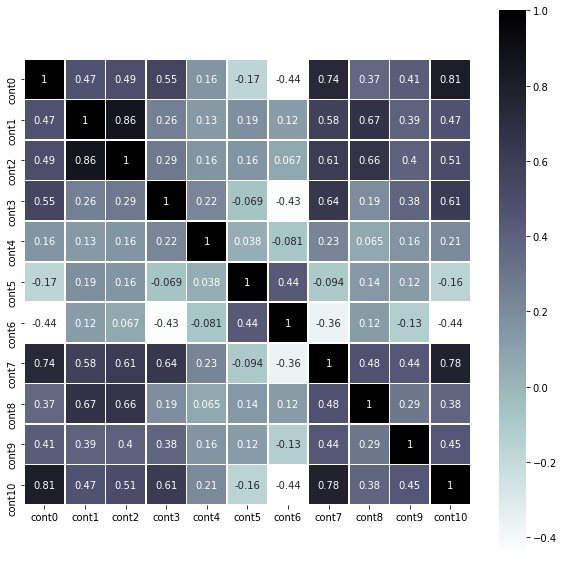

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(traindf.drop(columns=['target']).corr(), square=True, linewidths=0.7, cmap="bone_r", annot=True);

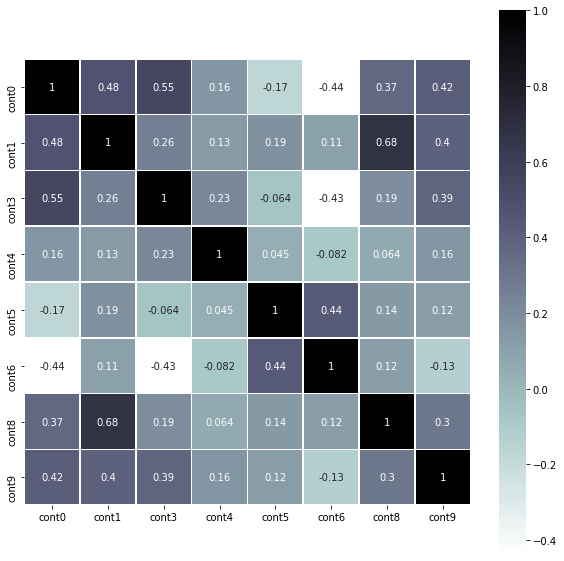

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(testdf.corr(), square=True, linewidths=0.7, cmap="bone_r", annot=True);

In [4]:
# final after drops and all
traindf.drop(columns=['cat5', 'cat13', 'cont2', 'cont7', 'cont10'], inplace=True)
testdf.drop(columns=['cat5', 'cat13', 'cont2', 'cont7', 'cont10'], inplace=True)

In [ ]:
for col in catcols:
    print(traindf[col].nunique())

In [ ]:
for col in catcols:
    print(testdf[col].nunique())

In [9]:
traindf

,cat0,cat1,cat2,cat3,cat4,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont3,cont4,cont5,cont6,cont8,cont9,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,A,I,A,B,B,A,S,Q,A,LO,A,A,A,B,D,D,B,0.629858,0.855349,0.795549,0.681917,0.621672,0.592184,0.815254,0.965006,0
1,A,I,A,A,E,K,W,AD,F,HJ,A,B,B,D,B,D,B,0.370727,0.328929,0.541366,0.388982,0.357778,0.600044,0.399353,0.927406,0
2,A,K,A,A,E,A,E,BM,L,DJ,A,B,A,B,D,D,B,0.502272,0.322749,0.616352,0.793687,0.552877,0.352113,0.412303,0.292696,0
3,A,K,A,C,E,A,Y,AD,F,KV,A,A,A,B,D,D,B,0.934242,0.707663,0.807807,0.800032,0.619147,0.221789,0.633669,0.760318,0
4,A,I,G,B,E,C,G,Q,A,DP,A,A,B,B,B,D,B,0.254427,0.274514,0.277308,0.610578,0.128291,0.578764,0.351103,0.357084,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,A,N,F,A,E,A,AS,K,A,HG,A,A,B,D,B,D,B,0.681700,0.500730,0.671927,0.390566,0.145840,0.262767,0.519340,0.617436,0
499995,A,K,A,A,G,A,K,AE,E,HK,A,B,B,B,D,D,B,0.489226,0.790664,0.620356,0.384891,0.735879,0.547731,0.470575,0.275743,0
499996,A,G,M,A,H,C,L,F,A,HC,B,A,B,D,B,D,D,0.487882,0.522347,0.232436,0.832482,0.810663,0.596939,0.373997,0.518024,1


#3. *`encodings`*
---

In [5]:
numcols = [col for col in traindf.columns if traindf[col].dtype != 'object']
catcols = [col for col in traindf.columns if col not in numcols]

In [6]:
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded = pd.DataFrame(onehot.fit_transform(traindf[catcols]), index=traindf.index)
traindf = pd.concat([traindf.drop(columns=catcols), encoded], axis=1)

encoded = pd.DataFrame(onehot.transform(testdf[catcols]), index=testdf.index)
testdf = pd.concat([testdf.drop(columns=catcols), encoded], axis=1)

In [ ]:
traindf

In [ ]:
testdf

#4. *`Preprocessing`*

In [7]:
#pca
X = traindf.drop(columns=['target'])
y = traindf['target']

In [8]:
from sklearn.decomposition import PCA
pca = PCA(40)
X = pd.DataFrame(pca.fit_transform(X), index=X.index)
testdf = pd.DataFrame(pca.transform(testdf), index=testdf.index)

In [9]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
X = pd.DataFrame(poly.fit_transform(X), index=X.index)

In [10]:
testdf = pd.DataFrame(poly.transform(testdf), index=testdf.index)

In [11]:
pca = PCA(250)
X = pd.DataFrame(pca.fit_transform(X), index=X.index)
testdf = pd.DataFrame(pca.transform(testdf), index=testdf.index)

In [26]:
explain[0:251].sum()

0.8449355872821792

In [21]:
X.shape

(300000, 821)

In [12]:
X.to_csv("X.csv")

In [ ]:
testdf.to_csv("test.csv")

#5. *`model`*

In [ ]:
xgbc = XGB

#6. *`submission`*
---